In [363]:
import os
os.chdir('/Users/beth/Documents/Metis/metis_project_2/metis_project2')
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


## Exploring the data

Import the dataframe scraped from Discogs.com and Spotify.com

In [364]:
with open('final_record_1000_manual_update.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

There are some null values, but only 2 nulls for the target value category (Median price).
Lowest price and highest price will be ignored.

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   artists                    1000 non-null   object
 1   albums                     1000 non-null   object
 2   artist_links               1000 non-null   object
 3   album_links                1000 non-null   object
 4   release_year               997 non-null    object
 5   label                      1000 non-null   object
 6   release_country            999 non-null    object
 7   total_artist_albums        989 non-null    object
 8   artist_last_years          989 non-null    object
 9   artist_first_years         989 non-null    object
 10  first_release_links        1000 non-null   object
 11  number_of_songs            1000 non-null   int64 
 12  average_song_length        794 non-null    object
 13  index                      1000 non-null   int64 
 14  users_hav

I need to convert a lot of these columns to numbers, and since NaN values can't be converted to integers, but can be convert to floats, I converted the values to floats

In [366]:
df['release_year'] = df['release_year'].astype('float')
df['total_artist_albums'] = df['total_artist_albums'].astype('float')
df['artist_last_years'] = df['artist_last_years'].astype('float')
df['artist_first_years'] = df['artist_first_years'].astype('float')
df['number_of_songs'] = df['number_of_songs'].astype('float')
df['users_have'] = df['users_have'].astype('float')
df['users_want'] = df['users_want'].astype('float')
df['user_rating'] = df['user_rating'].astype('float')
df['versions'] = df['versions'].astype('float')
df['spotify_monthly_listeners'] = df['spotify_monthly_listeners'].astype('float')

df['median_price'] = df['median_price'].str.replace(',','')
df['median_price'] = df['median_price'].astype('float')

df['number_for_sale'] = df['number_for_sale'].str.replace(',','')
df['number_for_sale'] = df['number_for_sale'].astype('float')

df.drop('highest_price', axis=1, inplace=True)
df.drop('lowest_price', axis=1, inplace=True)

### Creating new variables based on year or time differences

I changed some of the date and time columns to datetime objects, and I calculated some differences between times as new variables. For example, years_after_first_album represents the number of years the album of interest was released after the artist's first album was. I dropped columns that would be highly correlated with these new columns.

In [367]:
#the time since last sold as a number of days
df['last_sold'] = pd.to_datetime(df['last_sold'])
df['time_since_sold'] = datetime.today()-df['last_sold']
df = df.drop('last_sold', axis=1)
df['time_since_sold'] = df['time_since_sold'].dt.days

#the number of years the album was released after the artist's first album was 
#(measure of how established the artist was)
df['years_after_first_album']=df['release_year']-df['artist_first_years']
df=df.drop('artist_first_years',axis=1)

#the number of years since any album containing that artist's material was produced
#(measure of the relevance of the artist today)
df['years_since_any_album']=2020-df['artist_last_years']
df=df.drop('artist_last_years', axis=1)

#the number of years it has been since the album was released
df['years_since_release']=2020-df['release_year']
df=df.drop('release_year', axis=1)

#the average song length in minutes as a decimal float number
df['average_song_length'] = pd.to_datetime(df['average_song_length'])
df['average_song_length'] = df['average_song_length'].dt.hour + df['average_song_length'].dt.minute/60

I also dropped the link columns

In [368]:
df.drop(['artist_links', 'album_links', 'first_release_links'], axis=1, inplace=True)

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artists                    1000 non-null   object 
 1   albums                     1000 non-null   object 
 2   label                      1000 non-null   object 
 3   release_country            999 non-null    object 
 4   total_artist_albums        989 non-null    float64
 5   number_of_songs            1000 non-null   float64
 6   average_song_length        794 non-null    float64
 7   index                      1000 non-null   int64  
 8   users_have                 1000 non-null   float64
 9   users_want                 1000 non-null   float64
 10  user_rating                1000 non-null   float64
 11  median_price               978 non-null    float64
 12  styles                     1000 non-null   object 
 13  genres                     1000 non-null   object

### Looking at the distribution of the target variable (median price)

I looked at a histogram of my target variable 'median_price' and saw it was pretty skewed toward 0, and had a few very high outliers. I thought that transforming my target variable (predicting it thought a transformation link function) would be a good idea. I tried both the inverse (1/x) and the log (log(x)) of my target, and in a standard linear model using all of the data, the log of 'median_price' had a better R^2, meaning that the variables could predict the log 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


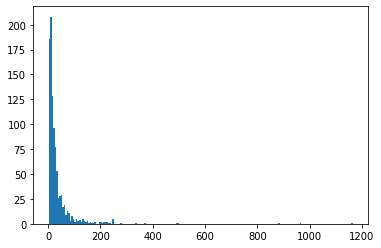

In [370]:
plt.hist(df['median_price'],bins=200);
#the warning is due to 2 np.nan values

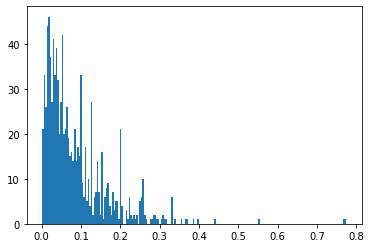

In [371]:
plt.hist(1/df['median_price'],bins=200);

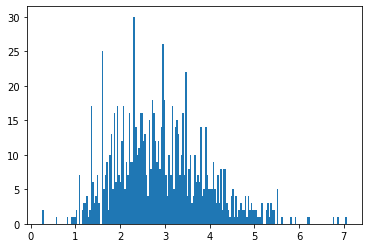

In [372]:
plt.hist(np.log(df['median_price']),bins=200);

I looked at the Pearson correlation between the continous variables in my dataframe, and added the log and inverse of median_price, to see if the correlations were better with either of these targets

In [374]:
df['log_median_price']=np.log(df['median_price'])
df['inv_median_price']=1/df['median_price']

### Plotting Pearson correlations between the predictors, target, and transformed targets

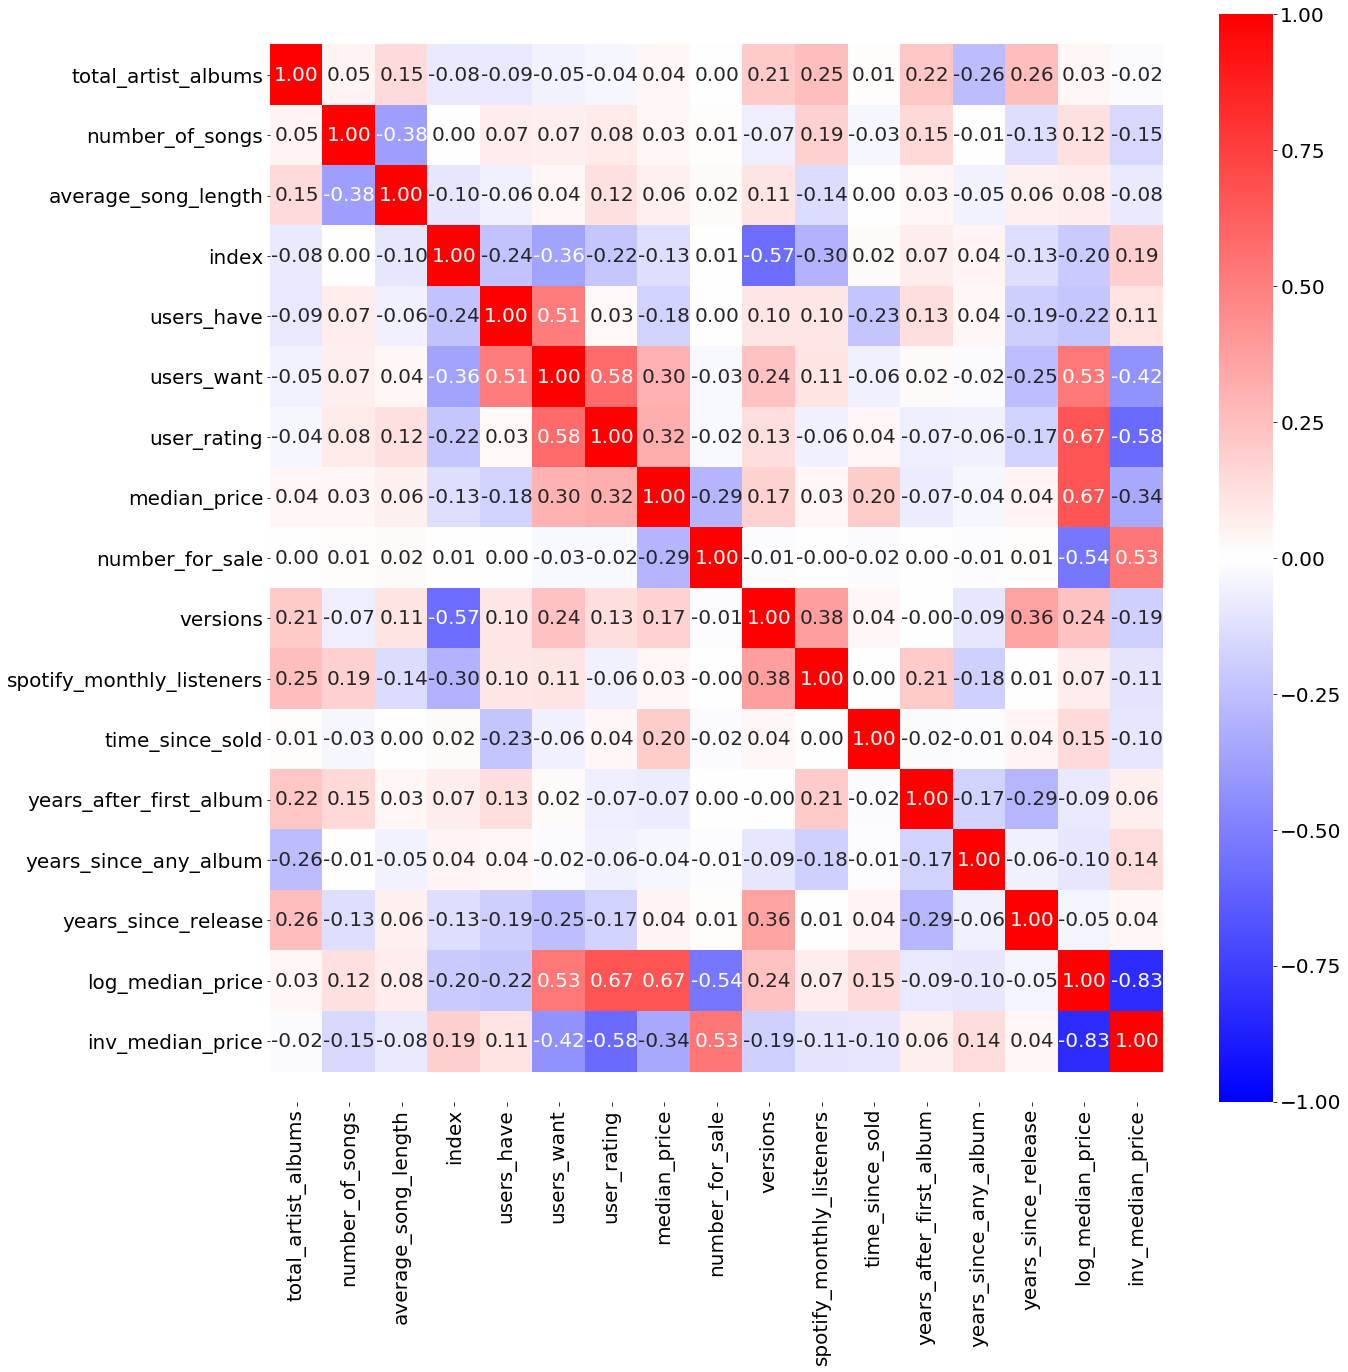

In [14]:
plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,20))

sns.heatmap(df.corr(), cmap="bwr", annot=True, vmin=-1, vmax=1, fmt='.2f')

plt.gca().set_ylim(len(df.corr())+0.5, -0.5);  # quick fix to make sure viz isn't cut off

From the above heatmap, it looks like my target median_price has a positive correlation with the number of versions (re-pressings) of the album made, as well as the user rating and the number of users that want the album. It has a negative correlation with the number for sale, the number of users that have the album, and the index (position in top 1000 collected albums list - not sure I want to use this variable in modeling). 

The inverse of median_price and log of median_price has higher linear correlations with the predictor variables. For inverse, the sign on the relationships is inverted. The log of the median price has the highest linear correlations with the predictor variables, so I am going to predict the log of the median value.


The variable 'spotify_monthly_listeners' is correlated with number of songs, and total number of artist albums, which makes sense because the more material the artist has produced, the more Spotify listens there may be by chance. However, it has no or very week correlation with the target varaible. 

The variable 'number_for_sale' seems the least correlated with any other variable, and only correlated with the target. 

The variable 'avg_song_length' has the most missing values, and isn't correlated with the target or other variables other than 'number_of_songs' so I am going to drop it.

In [375]:
df.drop('average_song_length', axis=1, inplace=True)

In [376]:
df.drop(['inv_median_price','median_price'], axis=1, inplace=True)

Based on intial pairplots I realized there were two very incorrect valuse of an album being released 20 years before the artist's first album, and over a million of a record for sale. I corrected these valuse in the dataframe

In [377]:
df.loc[541,'number_for_sale'] = 220
df.loc[983,'years_after_first_album']=0

### Pairplots to look at linearity of relationships, and for interesting patterns

This first pair plot using the continous variables that are related to things intrinsic to the album (not related to users)

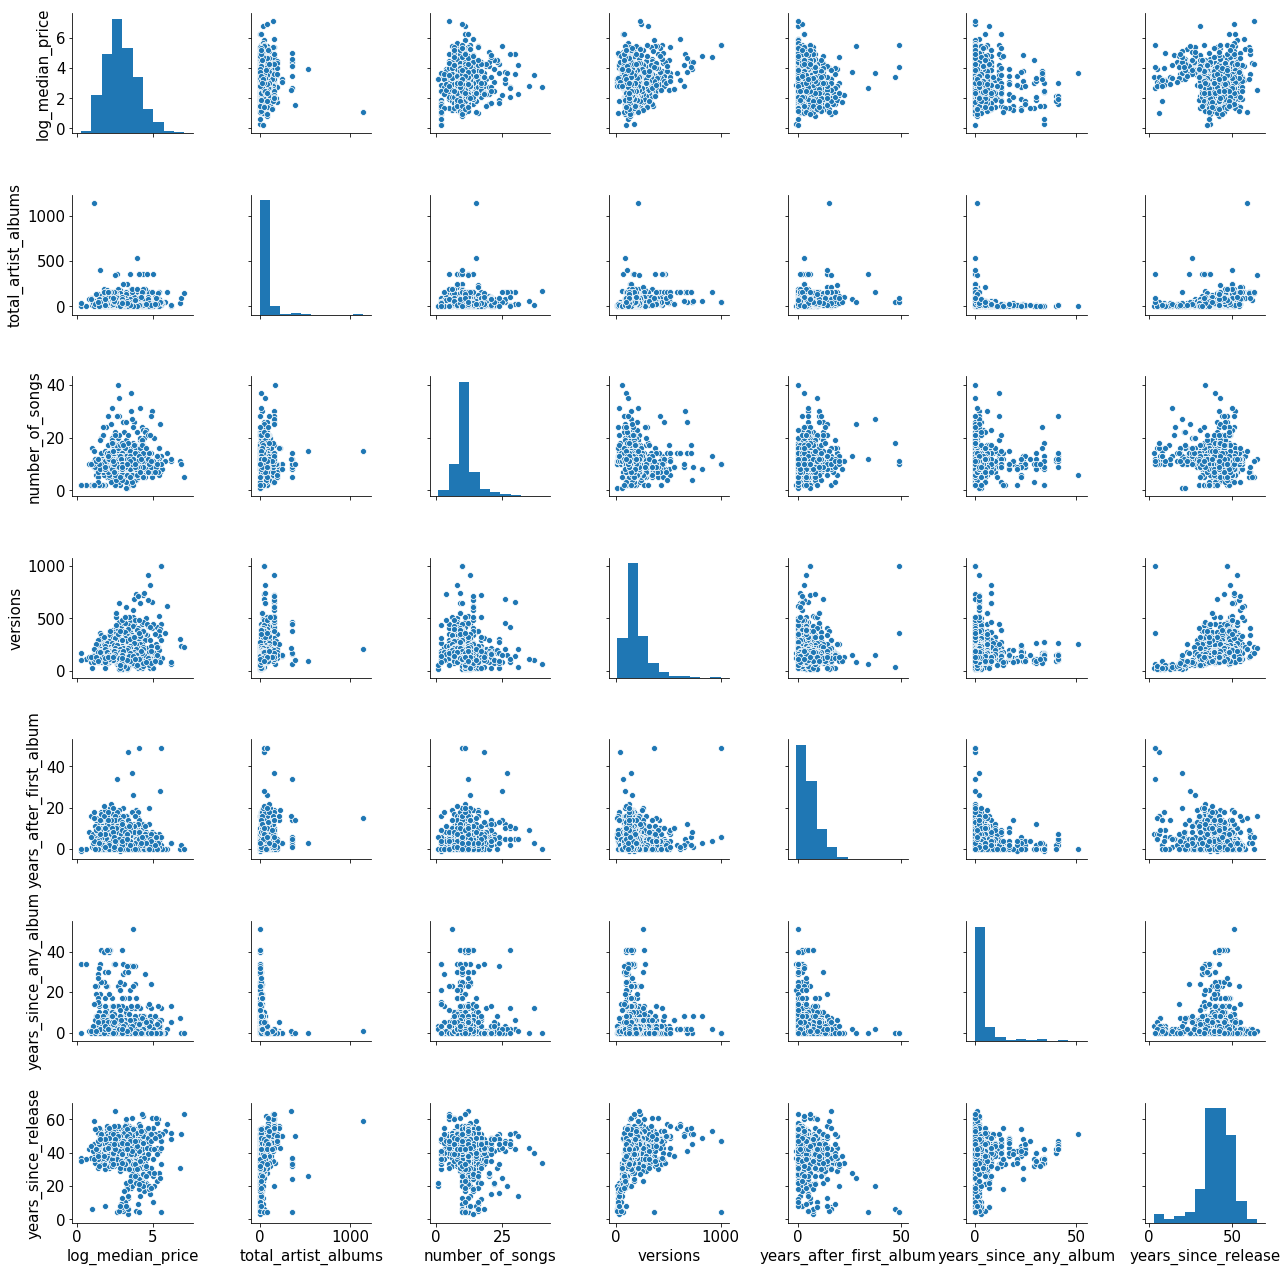

In [132]:
plt.rcParams['font.size'] = 15
sns.pairplot(data=df[['log_median_price','total_artist_albums','number_of_songs','versions','years_after_first_album','years_since_any_album','years_since_release']])

I can see the log_median_price has a somewhat linear positive relationship with number of songs and number of versions of that album. I interpret this as albums with more material being more valuable, and albums that earn money being re-pressed serveral times by record companies.

It has a somewhat linear negative relationshp with years_after_first_album and years_since_any_album. I interpret this as artist's early albums being more expensive, and record companies continuing to put out albums using material from artists they know will add more value to the record. Maybe the relationship with years_after_first_album is quadratic - newer compeliation albums of popular artists could also be more expensive.

The log_median_price has an unusual relationship with 'years_since_release'. It seems that album prices drop off sharply after a certain age. This may be because at that point the albums are all used and more likely damaged. I explore this plot more below.

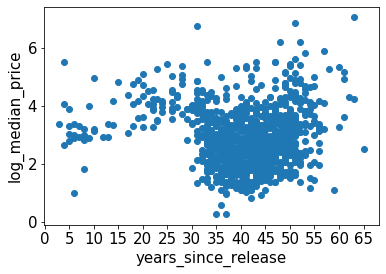

In [289]:
#It seems like when an album is less than 30 years old it sells for a higher price
#It might be useful to convert this into a categorical varialble (>30yr or <30yr)
#I keep the original 'years_since_release' since there seems to be a slight positive linear relationship overall

plt.scatter(df['years_since_release'], df['log_median_price'])
plt.xticks(np.arange(0, 70, step=5))
plt.xlabel('years_since_release')
plt.ylabel('log_median_price');

In [378]:
df['less_than_30_year_old']=df['years_since_release'] <= 30
df['more_than_30_year_old']=df['years_since_release'] > 30

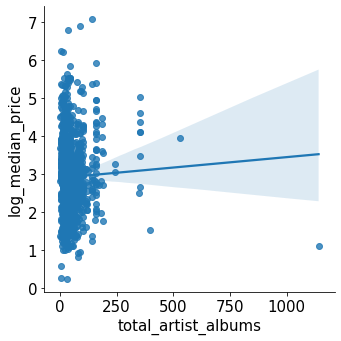

In [291]:
sns.lmplot('total_artist_albums','log_median_price',data=df)

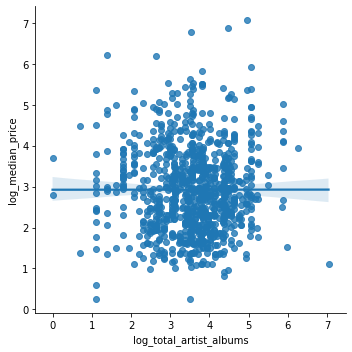

In [384]:
df['log_total_artist_albums']=np.log(df['total_artist_albums'])
sns.lmplot('log_total_artist_albums','log_median_price',data=df)

In [385]:
df.drop(['log_total_artist_albums', 'total_artist_albums'],axis=1,inplace=True)

Now I plotted several predicters related to how users interact with the albums and artists on Discogs and Spotify.

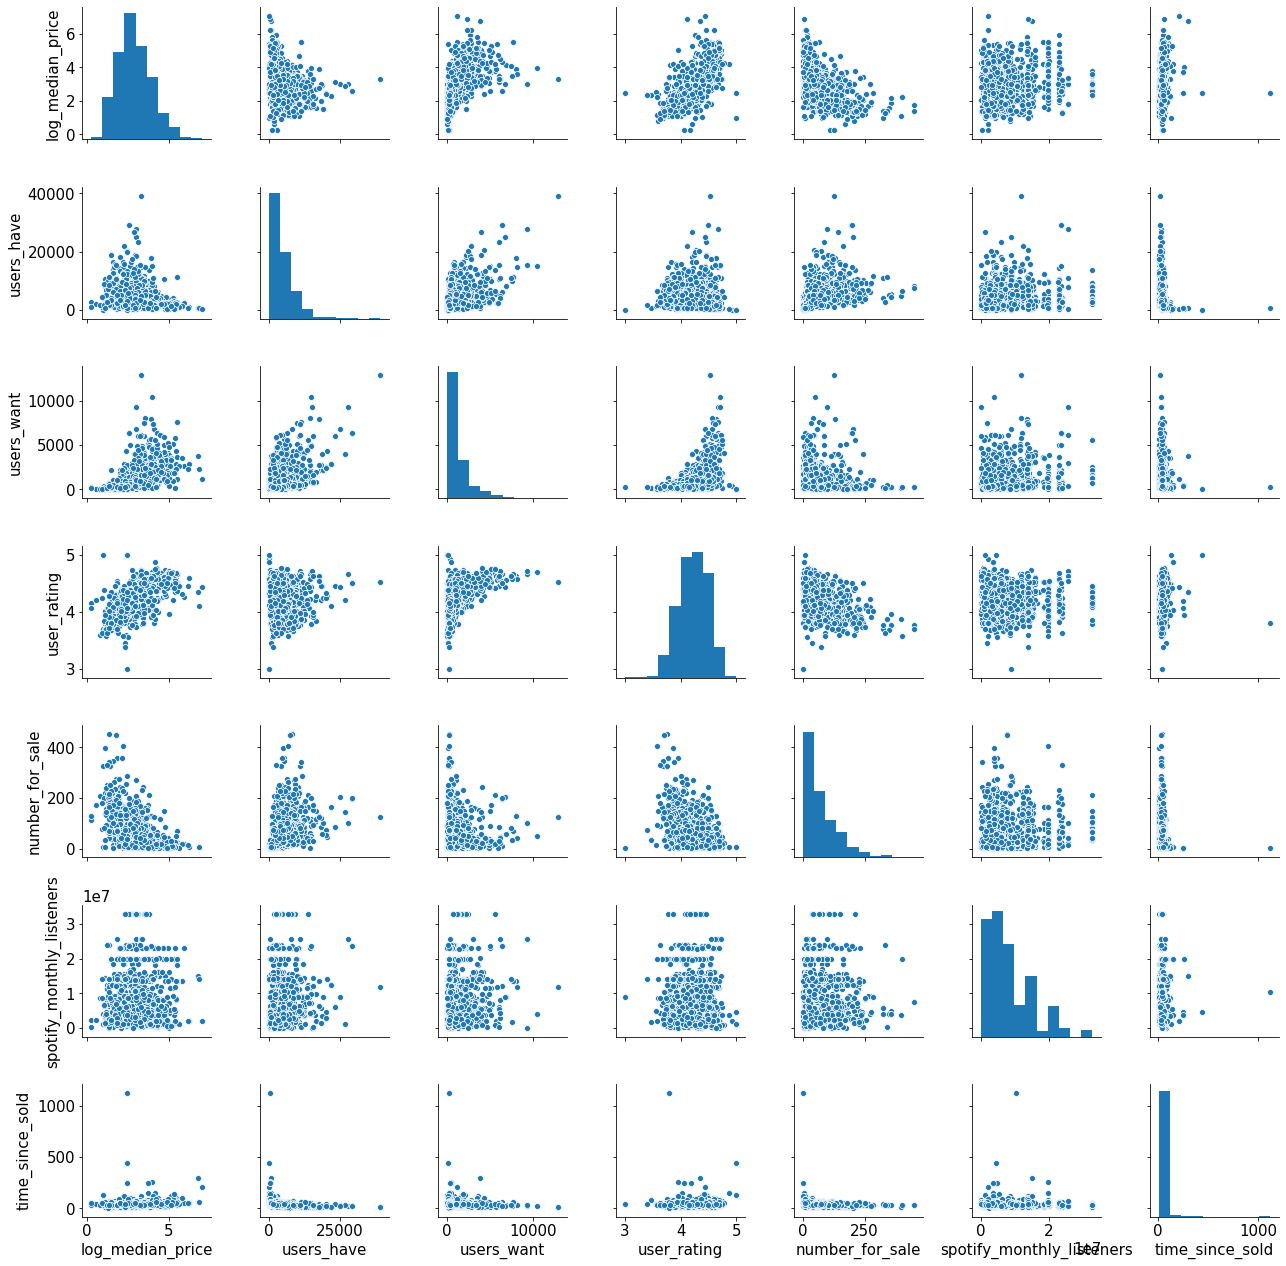

In [146]:
sns.pairplot(data=df[['log_median_price','users_have','users_want','user_rating','number_for_sale','spotify_monthly_listeners','time_since_sold']])

Here, 'log_median_price' has a positive relationship with users_want and user_rating. The relationship with users_want is not linear. 

'log_median_price' also has a negative non-linear relationship with number_for_sale. 

The variable 'time_since_sold' looked skewed toward 0, so I also tried log transforming it. Here a log transformation improved the linear relationship between it and 'log_median_price'.

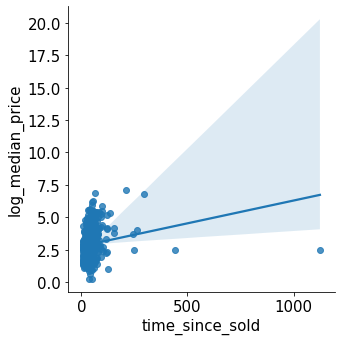

In [294]:
sns.lmplot('time_since_sold','log_median_price',data=df)

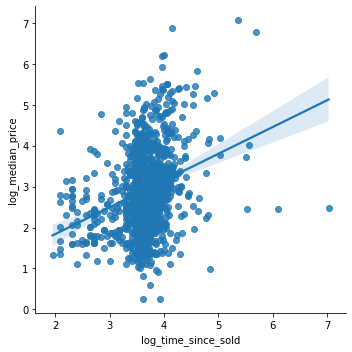

In [386]:
df['log_time_since_sold']=np.log(df['time_since_sold'])
sns.lmplot('log_time_since_sold','log_median_price',data=df)

In [387]:
df.drop('time_since_sold',axis=1,inplace=True)

### Important: 
Variables closely linked to market value like, supply (number_for_sale, time_since_sold), demand (users_want, users_have) were really strong predictors, especially once interaction terms were generated. In the end I decided to pursue a model that didn't use these variables, because it would be more challenging and the results may be more interesting.

## Creating the categorical variable columns

### Genre dummies

First, I viewed the genres and styles columns to look for popular tags. Sometimes a tag appears in genre and sometimes it appears in styles, tags are also non-exclusive because an album can be a fusion of multiple styles. I found all rows that contained a tag of interest and created a column for that tag of 1's and 0's.

In [308]:
df['styles'].value_counts().head(20)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Pop Rock]                        59
[Hard Rock]                       32
[Synth-pop]                       29
[Prog Rock]                       23
[Hard Rock, Heavy Metal]          22
[Heavy Metal]                     20
[Classic Rock]                    20
[]                                18
[Indie Rock]                      13
[Pop Rock, Classic Rock]          12
[Folk Rock]                       10
[Pop Rock, Synth-pop]             10
[New Wave]                        10
[Alternative Rock, Indie Rock]     9
[Blues Rock]                       9
[Hard Rock, Pop Rock]              8
[New Wave, Synth-pop]              8
[Hard Rock, Prog Rock]             8
[Soft Rock, Pop Rock]              7
[Alternative Rock]                 7
Name: styles, dtype: int64

In [388]:
df['Classic_Rock'] = df['styles'].apply(lambda x: 'Classic Rock' in x)
df['Classic_Rock_2'] = df['genres'].apply(lambda y: 'Classic Rock' in y)
df['Classic_Rock'] = df['Classic_Rock'] | df['Classic_Rock_2']
df.drop('Classic_Rock_2',axis=1,inplace=True)

In [389]:
df['Pop_Rock'] = df['styles'].apply(lambda x: 'Pop Rock' in x)
df['Pop_Rock_2'] = df['genres'].apply(lambda y: 'Pop Rock' in y)
df['Pop_Rock'] = df['Pop_Rock'] | df['Pop_Rock_2']
df.drop('Pop_Rock_2',axis=1,inplace=True)

In [390]:
df['Prog_Rock'] = df['styles'].apply(lambda x: 'Prog Rock' in x)
df['Prog_Rock_2'] = df['genres'].apply(lambda y: 'Prog Rock' in y)
df['Prog_Rock'] = df['Prog_Rock'] | df['Prog_Rock_2']
df.drop('Prog_Rock_2',axis=1,inplace=True)

In [391]:
df['Heavy_Metal'] = df['styles'].apply(lambda x: 'Hard Rock' in x or 'Heavy Metal' in x)
df['Heavy_Metal_2'] = df['genres'].apply(lambda y: 'Hard Rock' in y or 'Heavy Metal' in y)
df['Heavy_Metal'] = df['Heavy_Metal_2'] | df['Heavy_Metal']
df.drop('Heavy_Metal_2',axis=1,inplace=True)

In [392]:
df['Folk'] = df['styles'].apply(lambda x: 'Folk' in x or 'Folk Rock' in x)
df['Folk_2'] = df['genres'].apply(lambda y: 'Folk' in 'Fold Rock' in y)
df['Folk'] = df['Folk_2'] | df['Folk']
df.drop('Folk_2',axis=1,inplace=True)

In [393]:
df['New_Wave'] = df['styles'].apply(lambda x: 'New Wave' in x or 'Synth-Pop' in x)
df['New_Wave_2'] = df['genres'].apply(lambda y: 'New Wave' in y or 'Synth-Pop' in y)
df['New_Wave'] = df['New_Wave'] | df['New_Wave_2']
df.drop('New_Wave_2',axis=1,inplace=True)

In [394]:
df['Electronic'] = df['styles'].apply(lambda x: 'Electronic' in x)
df['Electronic_2'] = df['genres'].apply(lambda y: 'Electronic' in y)
df['Electronic'] = df['Electronic'] | df['Electronic_2']
df.drop('Electronic_2',axis=1,inplace=True)

In [395]:
df['Hip_Hop'] = df['styles'].apply(lambda x: 'Hip Hop' in x)
df['Hip_Hop_2'] = df['genres'].apply(lambda y: 'Hip Hop' in y)
df['Hip_Hop'] = df['Hip_Hop'] | df['Hip_Hop_2']
df.drop('Hip_Hop_2',axis=1,inplace=True)

In [396]:
df['Blues'] = df['styles'].apply(lambda x: 'Blues' in x or 'Blues Rock' in x)
df['Blues_2'] = df['genres'].apply(lambda y: 'Blues' in y or 'Blues Rock' in y)
df['Blues'] = df['Blues'] | df['Blues_2']
df.drop('Blues_2',axis=1,inplace=True)

In [397]:
df['Jazz'] = df['styles'].apply(lambda x: 'Jazz' in x)
df['Jazz_2'] = df['genres'].apply(lambda y: 'Jazz' in y)
df['Jazz'] = df['Jazz'] | df['Jazz_2']
df.drop('Jazz_2',axis=1,inplace=True)

In [398]:
df['Funk'] = df['styles'].apply(lambda x: 'Funk / Soul' in x)
df['Funk_2'] = df['genres'].apply(lambda y: 'Funk / Soul' in y)
df['Funk'] = df['Funk'] | df['Funk_2']
df.drop('Funk_2',axis=1,inplace=True)

In [399]:
df['Soundtrack'] = df['styles'].apply(lambda x: 'Stage & Screen' in x or 'Soundtrack' in x)
df['Soundtrack_2'] = df['genres'].apply(lambda y: 'Stage & Screen' in y or 'Soundtrack' in y)
df['Soundtrack'] = df['Soundtrack'] | df['Soundtrack_2']
df.drop('Soundtrack_2',axis=1,inplace=True)

In [400]:
df['Classic_Rock'] = df['Classic_Rock'].astype(int)
df['Pop_Rock'] = df['Pop_Rock'].astype(int)
df['Prog_Rock'] = df['Prog_Rock'].astype(int)
df['Heavy_Metal'] = df['Heavy_Metal'].astype(int)
df['Folk'] = df['Folk'].astype(int)
df['New_Wave'] = df['New_Wave'].astype(int)
df['Electronic'] = df['Electronic'].astype(int)
df['Hip_Hop'] = df['Hip_Hop'].astype(int)
df['Jazz'] = df['Jazz'].astype(int)
df['Funk'] = df['Funk'].astype(int)
df['Soundtrack'] = df['Soundtrack'].astype(int)

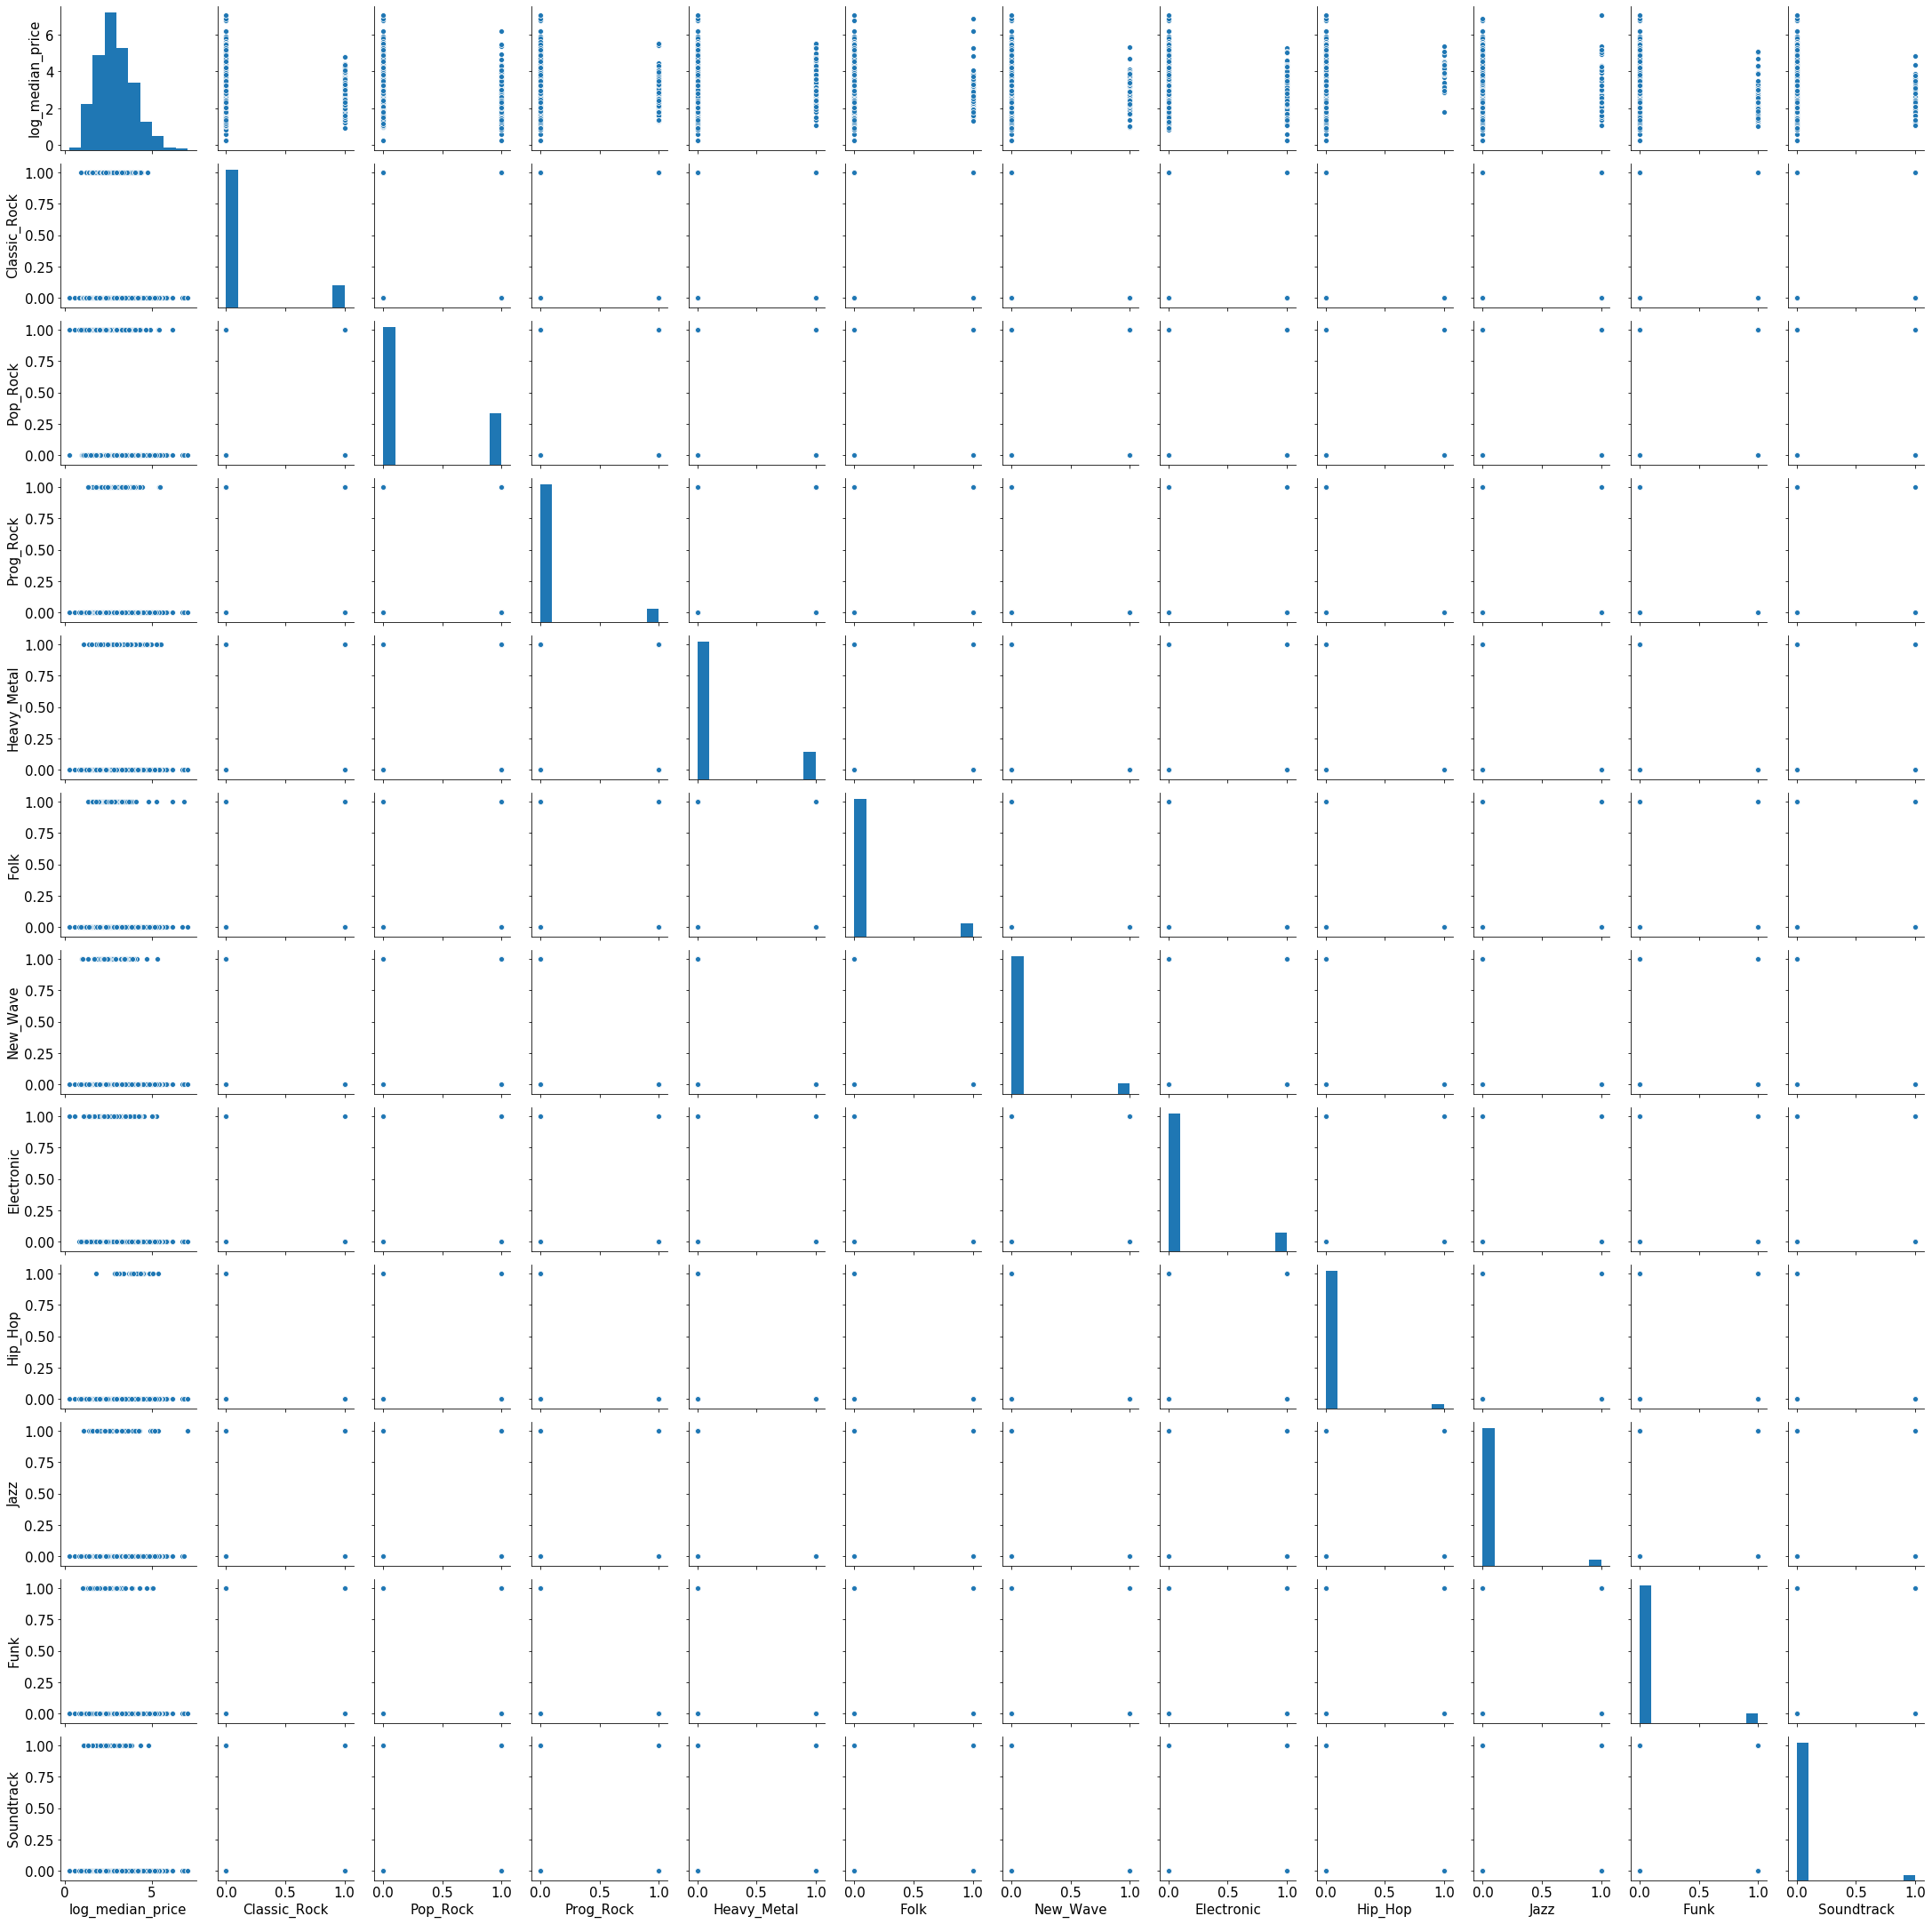

In [318]:
sns.pairplot(df[['log_median_price','Classic_Rock','Pop_Rock','Prog_Rock','Heavy_Metal','Folk','New_Wave','Electronic','Hip_Hop','Jazz','Funk','Soundtrack']])

From the above plot I can see some differences in the price distributions of the different genres/styles

There are the most Pop_Rock albums, they are usually older and cheaper.

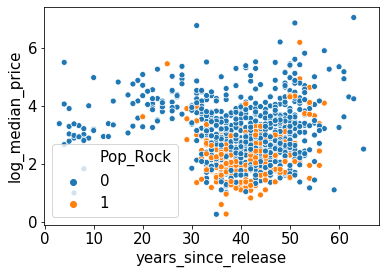

In [213]:
sns.scatterplot(df['years_since_release'],df['log_median_price'],hue=df['Pop_Rock'])

Jazz albums are amoung the oldest

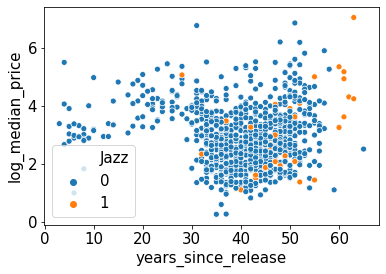

In [217]:
sns.scatterplot(df['years_since_release'],df['log_median_price'],hue=df['Jazz'])

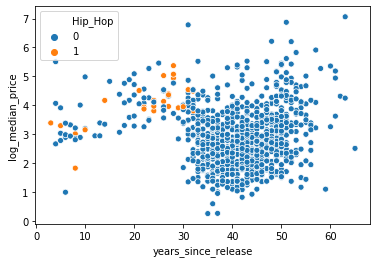

In [348]:
sns.scatterplot(df['years_since_release'],df['log_median_price'],hue=df['Hip_Hop'])

### Country dummies
I created country of album release dummy variables, and selected a few more common ones to keep.

In [401]:
country = pd.get_dummies(df['release_country'])

In [402]:
country.head()

,Australia,Australia & New Zealand,Canada,Europe,France,Germany,Italy,Japan,Netherlands,Sweden,UK,UK & Europe,UK & Ireland,"UK, Europe & US",US,USA & Canada,USA & Europe
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [403]:
df['release_country'].value_counts().head(10)

US                 472
UK                 410
Europe              40
UK & Europe         17
Australia           13
Canada              13
Germany             11
Sweden               7
UK, Europe & US      4
France               4
Name: release_country, dtype: int64

In [404]:
country = country[['US','UK','Europe','UK & Europe','Canada','Australia','Germany']]

I also created an artists dummy variable and kept the top 10 artists as variables

In [405]:
artist = pd.get_dummies(df['artists'])

In [406]:
df['artists'].value_counts().head(10)

The Beatles           24
Pink Floyd            20
David Bowie           19
Bob Dylan             19
The Rolling Stones    18
Queen                 14
Genesis               14
Depeche Mode          14
AC/DC                 12
Iron Maiden           11
Name: artists, dtype: int64

In [407]:
top_artists=list(df['artists'].value_counts().head(10).index)

In [408]:
artist = artist[top_artists]

In [409]:
artist

,The Beatles,Pink Floyd,David Bowie,Bob Dylan,The Rolling Stones,Queen,Genesis,Depeche Mode,AC/DC,Iron Maiden
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0
998,0,0,1,0,0,0,0,0,0,0


### Label Dummies
I did the same for the record labels variable

In [410]:
label = pd.get_dummies(df['label'])

In [411]:
label.columns

Index(['20th Century Records', '4AD', 'A&M Records', 'ABC Records',
       'ABC/Dunhill Records', 'ARC (3)', 'ATCO Records',
       'Aftermath Entertainment', 'Albert Productions', 'Anthem (5)',
       ...
       'WWA Records', 'Warner Bros. - Seven Arts Records',
       'Warner Bros. Records', 'Warp Records', 'Westbound Records',
       'Wilbury Records', 'Wild Bunch Records', 'XL Recordings', 'ZTT',
       'Zappa Records'],
      dtype='object', length=184)

In [412]:
df['label'].value_counts().head(10)

Columbia                90
Warner Bros. Records    48
Island Records          40
EMI                     37
Atlantic                30
Elektra                 29
Capitol Records         26
Epic                    26
A&M Records             25
Vertigo                 21
Name: label, dtype: int64

In [413]:
top_labels=list(df['label'].value_counts().head(10).index)
top_labels

['Columbia',
 'Warner Bros. Records',
 'Island Records',
 'EMI',
 'Atlantic',
 'Elektra',
 'Capitol Records',
 'Epic',
 'A&M Records',
 'Vertigo']

In [414]:
label = label[top_labels]

In [415]:
pd.concat([df,label,country,artist],axis=1).shape

(1000, 62)

In [416]:
df=pd.concat([df,label,country,artist],axis=1)

Saving an updated version of the data frame

In [336]:
import pickle
with open('feature_engineering_df_1.pickle', 'wb') as write_file:
    pickle.dump(df, write_file)

In [604]:
import pickle
with open('feature_engineering_df_1.pickle', 'rb') as read_file:
    df=pickle.load(read_file)

In [605]:
df.shape

(1000, 62)

Drop some columns that were replaced by dummies, were not meant to be analyzed or I no longer want in the analysis

In [606]:

df.drop(['top_artists_spotify_name','top_artists_orig_name'],axis=1, inplace=True)

In [607]:
df.drop(['label','release_country','index','styles','genres'],axis=1, inplace=True)

In [608]:
df.drop(['users_have', 'users_want', 'number_for_sale', 'log_time_since_sold'], axis=1, inplace=True)

## Train/test split

In [609]:
from sklearn.model_selection import train_test_split

In [610]:
df.dropna(how='any',axis=0,inplace=True)

The train test split with an 80-20 split. This 20% of the data in the test split I should NOT use to create my model in any way.

In [611]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'log_median_price'], df['log_median_price'], test_size=0.2, stratify=df[['US','UK','Europe','UK & Europe','Canada','Australia','Germany']])

In [612]:
X_train.iloc[:,2:].head()

,number_of_songs,user_rating,versions,spotify_monthly_listeners,years_after_first_album,years_since_any_album,years_since_release,less_than_30_year_old,more_than_30_year_old,Classic_Rock,...,The Beatles,Pink Floyd,Bob Dylan,David Bowie,The Rolling Stones,Genesis,Depeche Mode,Queen,AC/DC,Various
168,14.0,4.54,249.0,9246991.0,4.0,0.0,54.0,False,True,0,...,0,0,1,0,0,0,0,0,0,0
282,9.0,3.94,131.0,4577135.0,3.0,0.0,37.0,False,True,0,...,0,0,0,0,0,0,0,0,0,0
418,10.0,4.16,129.0,3279608.0,2.0,9.0,39.0,False,True,0,...,0,0,0,0,0,0,0,0,0,0
858,12.0,4.15,147.0,4038542.0,7.0,41.0,42.0,False,True,0,...,0,0,0,0,0,0,0,0,0,0
939,22.0,4.35,104.0,8735607.0,5.0,3.0,48.0,False,True,1,...,0,0,0,0,0,0,0,0,0,0


## Exploration of polynomial and interaction variables

Working with training data, I explored polynomial and interaction variables since I noticed they may be present in data visualization above. I used a naive approach to identify terms that may have predictive power, by creating all possible terms and then creating a model with statsmodel OLS. I looked at the terms with coefficients that had low p-value and graphed them to find interesting ones.

I could have also done a Lasso regression and looked at the highest value coefficients from that regression, but I did it this way originally. I like the idea of using the p-value, because sometimes a coefficent can be large but it's estimate has high variance so it is might not be different from 0. Lasso might change those coefficients to 0, but I'm not sure. 

In [9]:
from sklearn.preprocessing import PolynomialFeatures

In [43]:
p = PolynomialFeatures()
X_train_poly = p.fit_transform(X_train.iloc[:,2:])

Linear model with continuous features from statsmodel

In [44]:
import statsmodels.api as sm

In [45]:
import numpy as np

In [46]:
Y_sm = np.array(y_train)
X_sm = X_train_poly

In [47]:
model = sm.OLS(Y_sm, sm.add_constant(X_sm)) 

In [48]:
fit = model.fit()

In [49]:
fit.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     38.17
Date:                Wed, 07 Oct 2020   Prob (F-statistic):          1.06e-186
Time:                        15:07:40   Log-Likelihood:                -512.46
No. Observations:                 764   AIC:                             1155.
Df Residuals:                     699   BIC:                             1456.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.220      0.826      -0.005       0.004
x1            -0.0078      0.016     -0.471      0.638      -0.040       0.025
x2             0.0170      0.006      2.905      0.004       0.006       0.029
x3             0.0052      0.004      1.176      0.240      -0.004       0.014
x4          1.285e-07   7.65e-08      1.680      0.093   -2.17e-08    2.79e-07
x5            -0.0015      0.018     -0.081      0.935      -0.037       0.034
x6            -0.0276      0.032     -0.862      0.389      -0.091       0.035
x7            -0.0965      0.020     -4.942      0.000      -0.135      -0.058
x8             0.0016      0.002      0.650      0.516      -0.003       0.006
x9            -0.0007      0.002     -0.388      0.698      -0.004       0.003
x10           -0.0007      0.001     -0.720      0.472      -0.003       0.001
x11            0.0045      0.003      1.764      0.078      -0.001       0.010
x12            0.0002      0.001      0.185      0.853      -0.001       0.002
x13            0.0111      0.005      2.237      0.026       0.001       0.021
x14           -0.0151      0.004     -3.822      0.000      -0.023      -0.007
x15           -0.0013      0.001     -1.545      0.123      -0.003       0.000
x16           -0.0096      0.006     -1.559      0.120      -0.022       0.002
x17           -0.0025      0.001     -1.778      0.076      -0.005       0.000
x18            0.0043      0.004      1.175      0.240      -0.003       0.011
x19           -0.0018      0.002     -1.169      0.243      -0.005       0.001
x20           -0.0055      0.002     -2.496      0.013      -0.010      -0.001
x21            0.0010      0.001      0.963      0.336      -0.001       0.003
x22           -0.0015      0.001     -1.328      0.185      -0.004       0.001
x23            0.0008      0.001      0.804      0.422      -0.001       0.003
x24            0.0004      0.001      0.541      0.589      -0.001       0.002
x25            0.0013      0.001      1.777      0.076      -0.000       0.003
x26            0.0004      0.001      0.524      0.600      -0.001       0.002
x27           -0.0035      0.002     -1.713      0.087      -0.008       0.001
x28            0.0051      0.002      2.059      0.040       0.000       0.010
x29            0.0020      0.001      2.261      0.024       0.000       0.004
x30            0.0010      0.001      0.811      0.418      -0.001       0.003
x31            0.0004      0.001      0.318      0.750      -0.002       0.003
x32            0.0064      0.007      0.897      0.370      -0.008       0.020
x33           -0.0137      0.006     -2.221      0.027      -0.026      -0.002
x34            0.0031      0.003      1.015      0.310      -0.003       0.009
x35           -0.0057      0.002     -2.601      0.009      -0.010      -0.001
x3

In [50]:
X_train_poly.shape

(764, 1225)

In [51]:
poly_features_names = p.get_feature_names(X_train.iloc[:,2:].columns)

In [52]:
highly_sig_poly_features = [i for i in range(len(fit.pvalues)) if fit.pvalues[i] < 0.01]

In [137]:
[poly_features_names[i] for i in highly_sig_poly_features]

['user_rating',
 'years_since_release',
 'Folk',
 'UK & Europe',
 'Canada',
 'Australia',
 'Bob Dylan',
 'The Rolling Stones',
 'number_of_songs Vertigo',
 'number_of_songs Australia',
 'number_of_songs The Beatles',
 'user_rating^2',
 'user_rating years_since_release',
 'user_rating Folk',
 'user_rating Funk',
 'user_rating Canada',
 'user_rating Australia',
 'user_rating Genesis',
 'versions spotify_monthly_listeners',
 'versions years_after_first_album',
 'versions Soundtrack',
 'versions Various',
 'spotify_monthly_listeners Island Records',
 'spotify_monthly_listeners The Beatles',
 'spotify_monthly_listeners Pink Floyd',
 'years_since_any_album Blues',
 'years_since_any_album EMI',
 'years_since_any_album Australia',
 'years_since_any_album The Beatles',
 'years_since_any_album Pink Floyd',
 'years_since_any_album Various',
 'years_since_release^2',
 'years_since_release more_than_30_year_old',
 'years_since_release Elektra',
 'years_since_release Vertigo',
 'years_since_release 

Some squared terms were suggested from this model:

In [613]:
X_train["user_rating**2"]= X_train["user_rating"]**2
X_train['years_since_release**2'] = X_train['years_since_release']**2
X_test['user_rating**2']=X_test['user_rating']**2
X_test['years_since_release**2'] = X_test['years_since_release']**2

In [60]:
import matplotlib.pyplot as plt

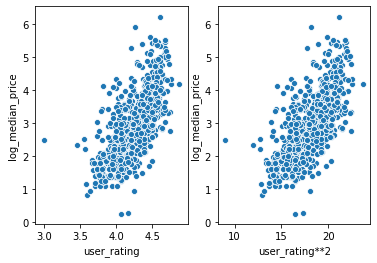

In [63]:
fig, axes = plt.subplots(1,2)
sns.scatterplot(ax=axes[0], x=X_train['user_rating'],y=y_train)
sns.scatterplot(ax= axes[1], x=X_train['user_rating**2'],y=y_train)

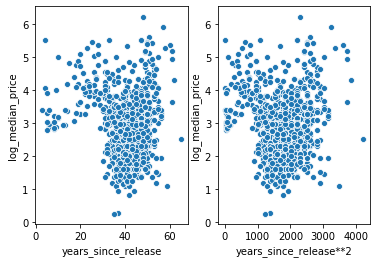

In [64]:
fig, axes = plt.subplots(1,2)
sns.scatterplot(ax=axes[0], x=X_train['years_since_release'],y=y_train)
sns.scatterplot(ax= axes[1], x=X_train['years_since_release**2'],y=y_train)

### Here I plotted and added some interaction terms to my train and test dataframes

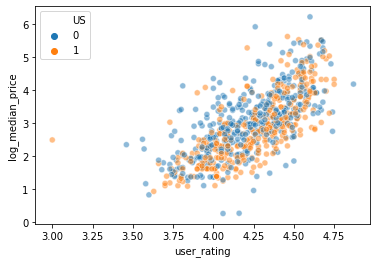

In [80]:
sns.scatterplot(X_train['user_rating'],y_train, hue=df['US'], alpha=0.5)

In [614]:
X_train['user_rating*US']=X_train['user_rating']*X_train['US']
X_test['user_rating*US']=X_test['user_rating']*X_test['US']

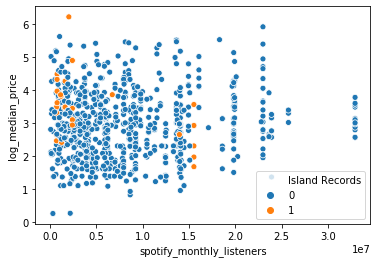

In [84]:
sns.scatterplot(X_train['spotify_monthly_listeners'],y_train, hue=df['Island Records'])

In [615]:
X_train['spotify*Island']=X_train['spotify_monthly_listeners']*X_train['Island Records']
X_test['spotify*Island']=X_test['spotify_monthly_listeners']*X_test['Island Records']

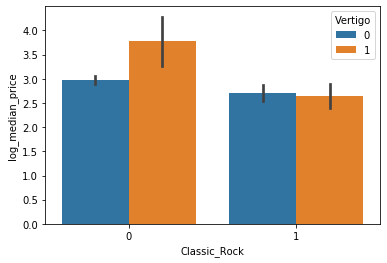

In [91]:
sns.barplot(X_train['Classic_Rock'],y_train, hue=df['Vertigo'])

In [616]:
X_train['Classic_Rock*Vertigo'] = X_train['Classic_Rock']*X_train['Vertigo']
X_test['Classic_Rock*Vertigo'] = X_test['Classic_Rock']*X_test['Vertigo']

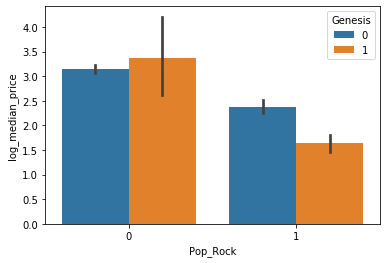

In [99]:
sns.barplot(X_train['Pop_Rock'],y_train, hue=df['Genesis'])

In [617]:
X_train['Pop_Rock*Genesis']=X_train['Pop_Rock']*X_train['Genesis']
X_test['Pop_Rock*Genesis']=X_test['Pop_Rock']*X_test['Genesis']

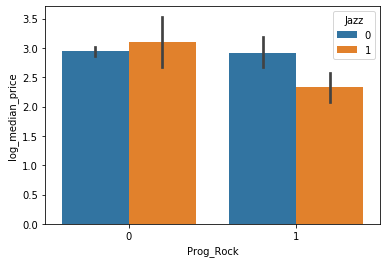

In [101]:
sns.barplot(X_train['Prog_Rock'],y_train, hue=df['Jazz'])

In [618]:
X_train['Prog_Rock*Jazz']=X_train['Prog_Rock']*X_train['Jazz']
X_test['Prog_Rock*Jazz']=X_test['Prog_Rock']*X_test['Jazz']

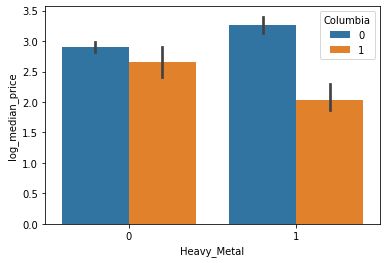

In [102]:
sns.barplot(X_train['Heavy_Metal'],y_train, hue=df['Columbia'])

In [619]:
X_train['Heavy_Metal*Columbia']=X_train["Heavy_Metal"]*X_train["Columbia"]
X_test['Heavy_Metal*Columbia']=X_test["Heavy_Metal"]*X_test["Columbia"]

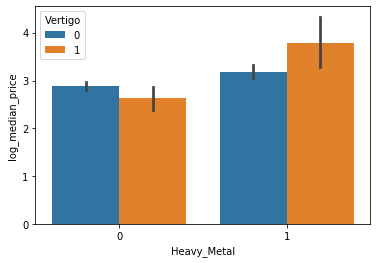

In [103]:
sns.barplot(X_train['Heavy_Metal'],y_train, hue=df['Vertigo'])

In [620]:
X_train['Heavy_Metal*Vertigo']=X_train["Heavy_Metal"]*X_train["Vertigo"]
X_test['Heavy_Metal*Vertigo']=X_test["Heavy_Metal"]*X_test["Vertigo"]

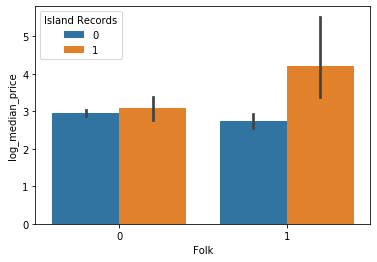

In [104]:
sns.barplot(X_train['Folk'],y_train, hue=df['Island Records'])

In [621]:
X_train['Folk*Island_Records']=X_train['Folk']*X_train['Island Records']
X_test['Folk*Island_Records']=X_test['Folk']*X_test['Island Records']

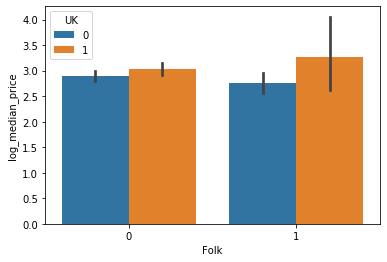

In [166]:
sns.barplot(X_train['Folk'],y_train, hue=df['UK'])

In [622]:
X_train['Folk*UK']=X_train['Folk']*X_train["UK"]
X_test['Folk*UK']=X_test['Folk']*X_test["UK"]

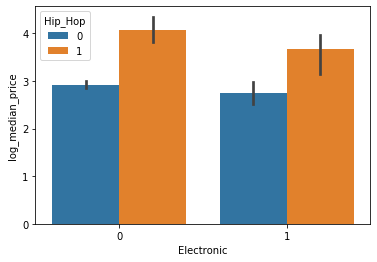

In [168]:
sns.barplot(X_train['Electronic'],y_train, hue=df['Hip_Hop'])

In [623]:
X_train['Hip_Hop*Electronic']=X_train["Hip_Hop"]*X_train["Electronic"]
X_test['Hip_Hop*Electronic']=X_test["Hip_Hop"]*X_test["Electronic"]

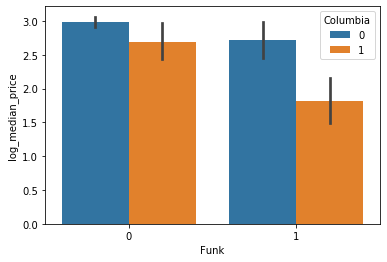

In [169]:
sns.barplot(X_train['Funk'],y_train, hue=df['Columbia'])

In [624]:
X_train['Funk*Columbia']=X_train['Funk']*X_train["Columbia"]
X_test['Funk*Columbia']=X_test['Funk']*X_test["Columbia"]

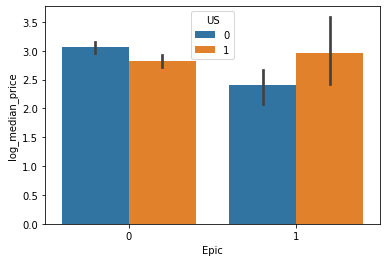

In [170]:
sns.barplot(X_train['Epic'],y_train, hue=df['US'])

In [625]:
X_train['Epic*US'] = X_train['Epic'] * X_train['US']
X_test['Epic*US'] = X_test['Epic'] * X_test['US']

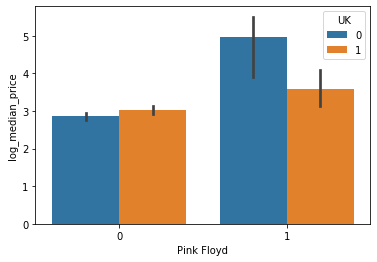

In [134]:
sns.barplot(X_train['Pink Floyd'],y_train, hue=df['UK'])

In [626]:
X_train['PinkFloyd*UK']=X_train["Pink Floyd"]*X_train["UK"]
X_test['PinkFloyd*UK']=X_test["Pink Floyd"]*X_test["UK"]

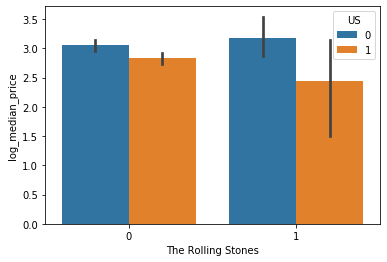

In [136]:
sns.barplot(X_train['The Rolling Stones'],y_train, hue=df['US'])

In [627]:
X_train['RollingStones*US']=X_train["The Rolling Stones"] * X_train['US']
X_test['RollingStones*US']=X_test["The Rolling Stones"] * X_test['US']

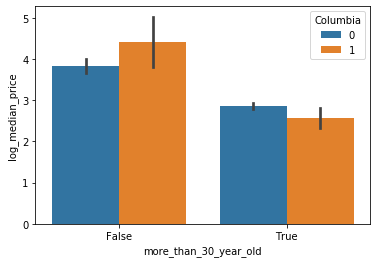

In [139]:
sns.barplot(X_train['more_than_30_year_old'],y_train, hue=df['Columbia'])

In [628]:
X_train['more_than_30*Columbia']=X_train['more_than_30_year_old']*X_train['Columbia']
X_test['more_than_30*Columbia']=X_test['more_than_30_year_old']*X_test['Columbia']

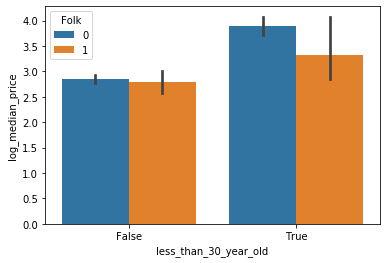

In [143]:
sns.barplot(X_train['less_than_30_year_old'],y_train, hue=df['Folk'])

In [629]:
X_train['less_than_30*Folk']=X_train["less_than_30_year_old"]*X_train["Folk"]
X_test['less_than_30*Folk']=X_test["less_than_30_year_old"]*X_test["Folk"]

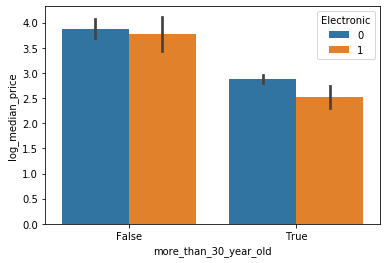

In [148]:
sns.barplot(X_train['more_than_30_year_old'],y_train, hue=df['Electronic'])

In [630]:
X_train['more_than_30*Electronic']=X_train['more_than_30_year_old']*X_train["Electronic"]
X_test['more_than_30*Electronic']=X_test['more_than_30_year_old']*X_test["Electronic"]



Excluding some of the others because they apply only to a small number of samples

In [631]:
X_train.columns

Index(['artists', 'albums', 'number_of_songs', 'user_rating', 'versions',
       'spotify_monthly_listeners', 'years_after_first_album',
       'years_since_any_album', 'years_since_release', 'less_than_30_year_old',
       'more_than_30_year_old', 'Classic_Rock', 'Pop_Rock', 'Prog_Rock',
       'Heavy_Metal', 'Folk', 'New_Wave', 'Electronic', 'Hip_Hop', 'Blues',
       'Jazz', 'Funk', 'Soundtrack', 'Columbia', 'Warner Bros. Records',
       'Island Records', 'EMI', 'Atlantic', 'Elektra', 'Epic',
       'Capitol Records', 'A&M Records', 'Vertigo', 'US', 'UK', 'Europe',
       'UK & Europe', 'Canada', 'Australia', 'Germany', 'The Beatles',
       'Pink Floyd', 'Bob Dylan', 'David Bowie', 'The Rolling Stones',
       'Genesis', 'Depeche Mode', 'Queen', 'AC/DC', 'Various',
       'user_rating**2', 'years_since_release**2', 'user_rating*US',
       'spotify*Island', 'Classic_Rock*Vertigo', 'Pop_Rock*Genesis',
       'Prog_Rock*Jazz', 'Heavy_Metal*Columbia', 'Heavy_Metal*Vertigo',
       'F

In [632]:
X_train.iloc[:,2:].shape

(771, 67)

In [633]:
X_train=X_train.reindex()
y_train=y_train.reindex()

### First linear model in sklearn, testing score by cross-validation

In [447]:
from sklearn.model_selection import KFold

In [448]:
from sklearn.linear_model import LinearRegression

In [664]:
kf = KFold(n_splits=10, shuffle=True)

cv_lm_r2s = [] 
cv_lm_MSEs = []

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = LinearRegression()
    
    #y_train_cv=np.array(y_train_cv).reshape(-1,1)
    #y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    cv_lm_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))
    cv_lm_MSEs.append((np.sum((lm.predict(X_train_cv.iloc[:,2:]) - y_train_cv)**2) / len(y_train_cv),np.sum((lm.predict(X_val.iloc[:,2:]) - y_val)**2) / len(y_val)))

In [665]:
cv_lm_r2s

[(0.6324839280369872, 0.5021154586885366),
 (0.6320937406593692, 0.538381301109149),
 (0.6258138735938608, 0.603115953174455),
 (0.6355706743431675, 0.5035925370347039),
 (0.6159781666357446, 0.4598995955860441),
 (0.6252376051401454, 0.6218457948824441),
 (0.6308405834722706, 0.5781911728231482),
 (0.6359698368009092, 0.4355628653430649),
 (0.6352595928674606, 0.39410734280290005),
 (0.62794363826928, 0.601029095887362)]

In [666]:
cv_lm_MSEs

[(0.4055057122492071, 0.4165232135473977),
 (0.3919765300046689, 0.5316340105726666),
 (0.4029289546869, 0.4254879567584764),
 (0.3956459481875239, 0.4927679700722372),
 (0.3972066637800124, 0.6941157931016025),
 (0.4063170278919393, 0.3800699165961457),
 (0.38265298042390083, 0.6024175100177367),
 (0.4079471897368458, 0.37194089393661844),
 (0.39622409450393614, 0.5861491266992753),
 (0.3973062210411607, 0.45961280129403936)]

In [667]:
np.mean(cv_lm_MSEs[1])

0.46180527028866775

The first column of training set R^2 is always higher than the test set R^2. It is overfit, and I should use Lasso or Ridge to increase fitting on test sets

In [572]:
y_val.shape

(154,)

In [573]:
X_val.shape

(154, 69)

In [574]:
y_train_cv.shape

(617,)

In [575]:
X_train_cv.shape

(617, 69)

### Scaling 

While variables do not need to be scaled for stanard linear regression, the penalities from Lasso and Ridge regression will not be able to be applied evenly on non-scaled variables. For Lasso and Ridge to perform optimally, I am going to scale my variables with StandardScaler (Z-score transformation).

In [457]:
from sklearn.preprocessing import StandardScaler

I need to scale the categorical varialbes as well, so the variables with more 1's don't have more weight in the penalty score from Lasso or Ridge. Since I am including categorical variables, I used with_mean=False)

In [638]:
scaler = StandardScaler()
X_train.iloc[:,2:] = scaler.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = scaler.fit_transform(X_test.iloc[:,2:])

In [639]:
X_train.describe()

,number_of_songs,user_rating,versions,spotify_monthly_listeners,years_after_first_album,years_since_any_album,years_since_release,less_than_30_year_old,more_than_30_year_old,Classic_Rock,...,Folk*Island_Records,Folk*UK,Hip_Hop*Electronic,Funk*Columbia,Epic*US,PinkFloyd*UK,RollingStones*US,more_than_30*Columbia,less_than_30*Folk,more_than_30*Electronic
count,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,...,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02,7.710000e+02
mean,-2.096608e-16,-1.772901e-15,-3.571145e-17,-1.175022e-16,-3.466747e-17,2.570361e-17,-2.200286e-16,-1.101583e-16,1.101583e-16,4.823926e-17,...,9.179860e-18,6.184705e-17,1.588296e-16,-4.564730e-17,3.072913e-16,2.312605e-16,9.179860e-18,-1.971330e-16,3.339309e-16,-2.384604e-16
std,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,...,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00,1.000649e+00
min,-2.357898e+00,-2.966896e+00,-1.489175e+00,-1.236566e+00,-1.128409e+00,-5.413812e-01,-3.895297e+00,-3.233953e-01,-3.092191e+00,-3.838247e-01,...,-6.250000e-02,-1.023959e-01,-5.099785e-02,-8.856149e-02,-1.309595e-01,-1.309595e-01,-6.250000e-02,-3.008710e-01,-5.099785e-02,-3.184785e-01
25%,-4.331343e-01,-7.419518e-01,-5.717596e-01,-7.465344e-01,-7.661341e-01,-5.413812e-01,-4.650035e-01,-3.233953e-01,3.233953e-01,-3.838247e-01,...,-6.250000e-02,-1.023959e-01,-5.099785e-02,-8.856149e-02,-1.309595e-01,-1.309595e-01,-6.250000e-02,-3.008710e-01,-5.099785e-02,-3.184785e-01
50%,-1.925388e-01,3.873034e-02,-2.464940e-01,-3.189589e-01,-2.227216e-01,-3.977950e-01,1.586863e-01,-3.233953e-01,3.233953e-01,-3.838247e-01,...,-6.250000e-02,-1.023959e-01,-5.099785e-02,-8.856149e-02,-1.309595e-01,-1.309595e-01,-6.250000e-02,-3.008710e-01,-5.099785e-02,-3.184785e-01
75%,2.886522e-01,7.803783e-01,3.289759e-01,6.038500e-01,3.206909e-01,3.296335e-02,6.784278e-01,-3.233953e-01,3.233953e-01,-3.838247e-01,...,-6.250000e-02,-1.023959e-01,-5.099785e-02,-8.856149e-02,-1.309595e-01,-1.309595e-01,-6.250000e-02,-3.008710e-01,-5.099785e-02,-3.184785e-01
max,7.025326e+00,3.044356e+00,6.725866e+00,3.643881e+00,7.928466e+00,6.781511e+00,2.549497e+00,3.092191e+00,3.233953e-01,2.605356e+00,...,1.600000e+01,9.766012e+00,1.960867e+01,1.129159e+01,7.635947e+00,7.635947e+00,1.600000e+01,3.323684e+00,1.960867e+01,3.139929e+00


### Lasso and Ridge with cross validation for identifying optimal alpha

In [460]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

LassoCV with 5 folds, to identify best alpha

In [668]:

lm = LassoCV(cv=10, n_alphas=1000, max_iter=5000)

lm.fit(X_train.iloc[:,2:],y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=1000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [669]:
lm.score(X_train.iloc[:,2:], y_train)

0.609430227465526

In [670]:
lm.score(X_test.iloc[:,2:], y_test)

0.4627877140606443

In [671]:
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)**2) / len(y_train)

0.4204019129473574

In [672]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)**2) / len(y_test)

0.5728824900857541

In [673]:
lasso_coef= lm.coef_

In [674]:
lasso_alpha=lm.alpha_
lasso_alpha

0.016541832893598958

In [676]:
kf = KFold(n_splits=10, shuffle=True, random_state = 71)

cv_lasso_r2s = [] 
cv_lasso_MSEs = []

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = Lasso(alpha=lasso_alpha, max_iter=5000)
    
    #y_train_cv=np.array(y_train_cv).reshape(-1,1)
    #y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    
    predictions=lm.predict(X_train_cv.iloc[:,2:])
    train_MSE=np.sum((predictions - y_train_cv)**2)/len(y_train_cv)
    
    val_predictions=lm.predict(X_val.iloc[:,2:])
    validation_MSE = np.sum((val_predictions - y_val)**2)/len(y_val)
    
    cv_lasso_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))
    cv_lasso_MSEs.append((train_MSE, validation_MSE))

In [677]:
cv_lasso_r2s

[(0.6100824403932676, 0.6093664213076997),
 (0.606206325364212, 0.5963728113643941),
 (0.6077809763722315, 0.6019468323891227),
 (0.6074685361810481, 0.5728527173616945),
 (0.631532283988176, 0.41543721418511037),
 (0.6162054692895412, 0.5281445070835997),
 (0.6110186781079174, 0.529228711333747),
 (0.6019269886282907, 0.6512461976964765),
 (0.6212231409806519, 0.4506218674743718),
 (0.6153880736312951, 0.5182005343129608)]

In [678]:
cv_lasso_MSEs

[(0.42218266657513637, 0.3962444307573863),
 (0.4112439114526813, 0.5440708345745983),
 (0.418649763943037, 0.44839018952032067),
 (0.41528379427723305, 0.5243726278890545),
 (0.39387911525124103, 0.6545098627947524),
 (0.4251938957511656, 0.3737916374379834),
 (0.42830553582105746, 0.3704110544686126),
 (0.4285318086111011, 0.3749188262820064),
 (0.4071056886095863, 0.5952375334553618),
 (0.4154213359327023, 0.4929795224397769)]

In [679]:
np.sqrt(np.array(cv_lasso_MSEs))

array([[0.64975585, 0.62947949],
       [0.64128302, 0.73761157],
       [0.6470315 , 0.66961944],
       [0.64442517, 0.72413578],
       [0.62759789, 0.80901784],
       [0.65206893, 0.61138502],
       [0.65445056, 0.60861404],
       [0.65462341, 0.61230615],
       [0.63804834, 0.77151639],
       [0.64453187, 0.702125  ]])

In [680]:
np.mean(cv_lasso_MSEs[1])

0.47765737301363975

RidgeCV with 5 folds

In [685]:
lm = RidgeCV(cv=10, alphas=(np.arange(0,1,0.1)))

lm.fit(X_train.iloc[:,2:],y_train)

RidgeCV(alphas=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), cv=10,
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [686]:
lm.score(X_train.iloc[:,2:], y_train)

0.6278231891827518

In [687]:
lm.score(X_test.iloc[:,2:], y_test)

0.44893021403508604

In [688]:
np.sum((lm.predict(X_train.iloc[:,2:]) - y_train)**2) / len(y_train)

0.40060407697937617

In [689]:
np.sum((lm.predict(X_test.iloc[:,2:]) - y_test)**2) / len(y_test)

0.5876601102720159

In [690]:
ridge_alpha=lm.alpha_

In [691]:
ridge_coef = lm.coef_

In [692]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

cv_ridge_r2s = [] 
cv_ridge_MSEs = []

for train_ind, val_ind in kf.split(X_train,y_train):
    #print(train_ind)
    X_train_cv, y_train_cv = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    #print(X_train_cv.shape)
    #print(X_val.shape)
    #print(y_train_cv.shape)
    #print(y_val.shape)
    #simple linear regression
    lm = Ridge(alpha=ridge_alpha)
    
    #y_train_cv=np.array(y_train_cv).reshape(-1,1)
    #y_val=np.array(y_val).reshape(-1,1)

    lm.fit(X_train_cv.iloc[:,2:], y_train_cv)
    cv_ridge_r2s.append((lm.score(X_train_cv.iloc[:,2:], y_train_cv),lm.score(X_val.iloc[:,2:], y_val)))
    cv_ridge_MSEs.append((np.sum((lm.predict(X_train_cv.iloc[:,2:]) - y_train_cv)**2) / len(y_train_cv),np.sum((lm.predict(X_val.iloc[:,2:]) - y_val)**2) / len(y_val)))

In [693]:
cv_ridge_r2s

[(0.6243716197503824, 0.5864055028793784),
 (0.6286394338891244, 0.5596717521187189),
 (0.6591942841172376, 0.4194114461579065),
 (0.6240681959515817, 0.5951639492299503),
 (0.6514017091674517, 0.43377988497237757)]

In [694]:
cv_ridge_MSEs

[(0.3935298037557693, 0.4920195867185205),
 (0.38847188589165693, 0.5270542644890509),
 (0.37608133988018916, 0.5589390127499835),
 (0.4151467055595723, 0.3835359656634234),
 (0.3759300270862368, 0.5968067116048094)]

In [695]:
np.sqrt(np.array(cv_lasso_MSEs))

array([[0.64975585, 0.62947949],
       [0.64128302, 0.73761157],
       [0.6470315 , 0.66961944],
       [0.64442517, 0.72413578],
       [0.62759789, 0.80901784],
       [0.65206893, 0.61138502],
       [0.65445056, 0.60861404],
       [0.65462341, 0.61230615],
       [0.63804834, 0.77151639],
       [0.64453187, 0.702125  ]])

In [696]:
np.mean(cv_ridge_MSEs[1])

0.4577630751903539

In [698]:
residuals = lm.predict(X_test.iloc[:,2:]) - y_test

In [705]:
predictions = lm.predict(X_test.iloc[:,2:])

In [708]:
residual_df = pd.DataFrame({'artist':X_test['artists'],'album':X_test['albums'],'price':2.17**y_test,'prediction':2.17**predictions})

In [711]:
pd.set_option('display.max_rows', 200)

residual_df

,artist,album,price,prediction
894,Slayer,Show No Mercy,29.810929,16.064975
74,Metallica,Kill 'Em All,35.436787,21.148436
292,Bowie,Pinups,11.505685,7.083212
266,Bruce Springsteen,Nebraska,7.511044,9.192574
420,Elton John,Captain Fantastic And The Brown Dirt Cowboy,7.498109,7.320094
354,Jackson Browne,Running On Empty,3.479454,4.056080
278,The Allman Brothers Band,The Allman Brothers Band At Fillmore East,15.712000,15.695453
447,Heart,Dreamboat Annie,6.086193,9.313958
943,Neworder,Technique,11.494260,9.637367
762,Bob Dylan,Another Side Of Bob Dylan,11.494260,10.311465


In [ ]:
residual_df[np.random.random]